In [25]:
import pandas as pd
import numpy as np
import PIL as pil
from PIL import Image as img
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil
from random import sample
import sys
import yaml
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [6]:
data_dir = (config['data']['clean']+'train')
categories = ['notumor', 'tumor']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img)) 

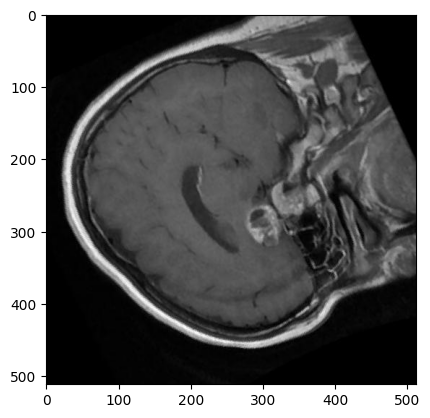

In [7]:
plt.imshow(img_array);

In [8]:
img_array.shape

(512, 512, 3)

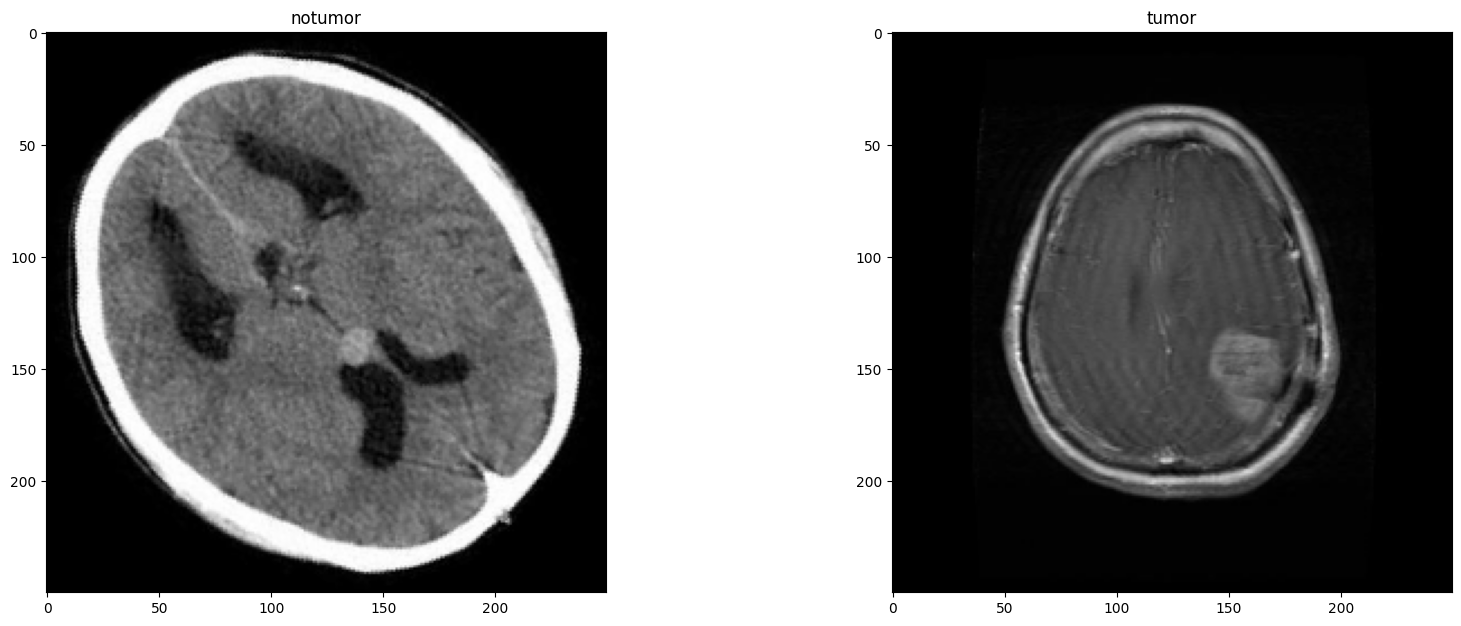

In [9]:
plt.figure(figsize=(20, 16))

images_path = ['/notumor/rt15rt210Te-no_0042.jpg', '/tumor/Te-gl_0023.jpg']

for i in range(2):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(categories[i])

In [17]:
model3 = Sequential()

# Layer 1
model3.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model3.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model3.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

# Connect layers
model3.add(Dense(units= 512, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units=1, activation='sigmoid', activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model3.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics= ['accuracy'])


model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3200      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        200768    
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                      

In [14]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)


train = generator_train.flow_from_directory(config['data']['clean']+'train', target_size=(64,64),
                                              batch_size=32, class_mode= "binary", color_mode='grayscale')

test = generator_test.flow_from_directory(config['data']['clean']+'test', target_size=(64,64),
                                              batch_size=32, class_mode= "binary", color_mode='grayscale')

Found 14066 images belonging to 2 classes.
Found 6026 images belonging to 2 classes.


In [15]:
model3_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 8, verbose = 1)
model3_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model3_mcp = ModelCheckpoint(filepath = config['models']+'binary_models/model3_weights.h5', monitor = 'val_accuracy', 
                      save_best_only = True, verbose = 1)

history3 = model3.fit(train, steps_per_epoch=14066//32, epochs=100, validation_data=test, validation_steps= 6026//32,
                     callbacks=[model3_es, model3_rlr, model3_mcp])

Epoch 1/100
439/439 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9176
Epoch 1: val_accuracy improved from -inf to 0.87666, saving model to ../models/binary_models/model3_weights.h5
439/439 [==============================] - 244s 554ms/step - loss: 0.2234 - accuracy: 0.9176 - val_loss: 0.4976 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 2/100
439/439 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9725
Epoch 2: val_accuracy improved from 0.87666 to 0.97789, saving model to ../models/binary_models/model3_weights.h5
439/439 [==============================] - 249s 568ms/step - loss: 0.0947 - accuracy: 0.9725 - val_loss: 0.0748 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 3/100
439/439 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9797
Epoch 3: val_accuracy did not improve from 0.97789
439/439 [==============================] - 251s 573ms/step - loss: 0.0739 - accuracy: 0.9797 - val_loss: 0.0914 - val_accuracy: 0.9731 - 

In [16]:
model3.evaluate(test)

189/189 [==============================] - 14s 73ms/step - loss: 0.0277 - accuracy: 0.9967


[0.027679769322276115, 0.9966810345649719]

In [18]:
model3.save('../models/binary_models/model3_bin.model')

INFO:tensorflow:Assets written to: ../models/binary_models/model3_bin.model/assets


INFO:tensorflow:Assets written to: ../models/binary_models/model3_bin.model/assets


In [19]:
preds = model3.predict_generator(test)

In [23]:
preds

array([[0.49701676],
       [0.4974182 ],
       [0.49830186],
       ...,
       [0.49768198],
       [0.4947508 ],
       [0.49821904]], dtype=float32)

In [20]:
predlist=[]
for i in preds:
    if (1-i) <= 0.5:
        predlist.append(0)
    else:
        predlist.append(1)

In [21]:
y_pred = predlist

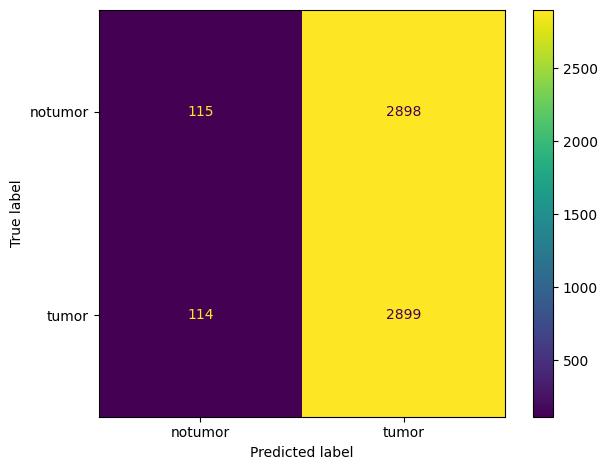

In [22]:
g_dict = test.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test.classes, predlist)
display_cm = ConfusionMatrixDisplay(cm, display_labels=classes)
display_cm.plot()
plt.tight_layout()
plt.show()

In [27]:
model4 = Sequential()

# Layer 1
model4.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model4.add(LayerNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model4.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model4.add(LayerNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model4.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model4.add(LayerNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())


# Connect layers
model4.add(Dense(units= 512, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(units=512, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(units=1, activation='sigmoid', activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model4.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics= ['accuracy'])


model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        3200      
                                                                 
 layer_normalization (LayerN  (None, 64, 64, 64)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        200768    
                                                                 
 layer_normalization_1 (Laye  (None, 32, 32, 64)       128       
 rNormalization)                                                 
                                                      

In [28]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)


train = generator_train.flow_from_directory(config['data']['clean']+'train', target_size=(64,64),
                                              batch_size=32, class_mode= "binary", color_mode='grayscale')

test = generator_test.flow_from_directory(config['data']['clean']+'test', target_size=(64,64),
                                              batch_size=32, class_mode= "binary", color_mode='grayscale')

Found 14066 images belonging to 2 classes.
Found 6026 images belonging to 2 classes.


In [31]:
model4_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 8, verbose = 1)
model4_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model4_mcp = ModelCheckpoint(filepath = config['models']+'binary_models/model4_weights.h5', monitor = 'val_accuracy', 
                      save_best_only = True, verbose = 1)

history4 = model4.fit(train, steps_per_epoch=14066//32, epochs=70, validation_data=test, validation_steps= 6026//32,
                     callbacks=[model4_es, model4_rlr, model4_mcp])

Epoch 1/70
439/439 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9243
Epoch 1: val_accuracy improved from -inf to 0.97124, saving model to ../models/binary_models/model4_weights.h5
439/439 [==============================] - 282s 641ms/step - loss: 0.1977 - accuracy: 0.9243 - val_loss: 0.1012 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 2/70
439/439 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9706
Epoch 2: val_accuracy improved from 0.97124 to 0.98039, saving model to ../models/binary_models/model4_weights.h5
439/439 [==============================] - 220s 500ms/step - loss: 0.0973 - accuracy: 0.9706 - val_loss: 0.0671 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 3/70
439/439 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9813
Epoch 3: val_accuracy improved from 0.98039 to 0.98853, saving model to ../models/binary_models/model4_weights.h5
439/439 [==============================] - 221s 503ms/step - loss: 0.0690 - a

In [32]:
model4.evaluate(test)

189/189 [==============================] - 21s 110ms/step - loss: 0.0525 - accuracy: 0.9955


[0.05247011035680771, 0.9955193996429443]

In [110]:
model4.save('../models/binary_models/model4_bin.model')

INFO:tensorflow:Assets written to: ../models/binary_models/model2_bin.model/assets


INFO:tensorflow:Assets written to: ../models/binary_models/model2_bin.model/assets


In [33]:
preds4 = model4.predict_generator(test)

In [34]:
preds4

array([[1.1635903e-07],
       [1.9233687e-10],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [8.4107008e-08],
       [1.0000000e+00]], dtype=float32)

In [35]:
predlist4=[]
for i in preds4:
    if (1-i) <= 0.5:
        predlist4.append(0)
    else:
        predlist4.append(1)

In [36]:
y_pred4 = predlist4

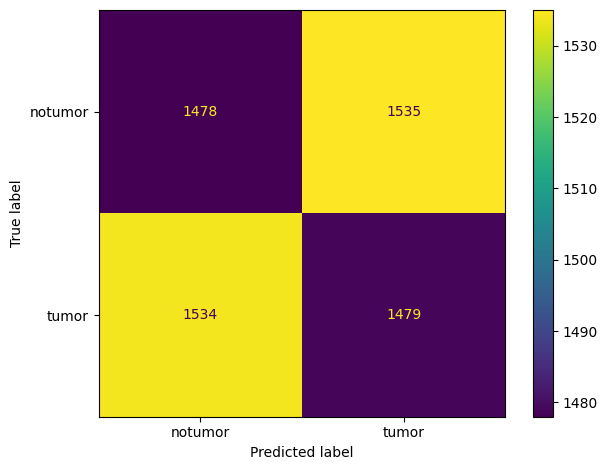

In [39]:
g_dict = test.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm4 = confusion_matrix(test.classes, predlist4)
display_cm4 = ConfusionMatrixDisplay(cm4, display_labels=classes)
display_cm4.plot()
plt.tight_layout()
plt.show()

In [41]:
preds4 = model4.predict_generator(test)
y_pred4 = np.argmax(preds4, axis=1)
print(y_pred4)

[0 0 0 ... 0 0 0]


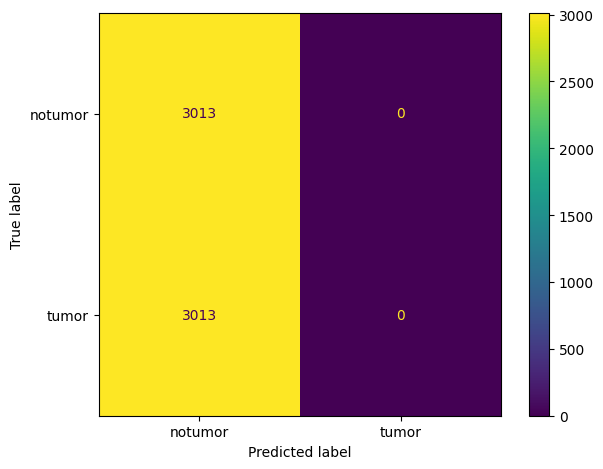

In [42]:
g_dict = test.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm4= confusion_matrix(test.classes, y_pred4)
display_cm4 = ConfusionMatrixDisplay(cm4, display_labels=classes)
display_cm4.plot()
plt.tight_layout()
plt.show()

In [43]:
model6 = Sequential()

# Layer 1
model6.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model6.add(LayerNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model6.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model6.add(LayerNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model6.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model6.add(LayerNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())


# Connect layers
model6.add(Dense(units= 512, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(units=512, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(units=1, activation='sigmoid', activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model6.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics= ['accuracy'])


model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        3200      
                                                                 
 layer_normalization_3 (Laye  (None, 64, 64, 64)       128       
 rNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        200768    
                                                                 
 layer_normalization_4 (Laye  (None, 32, 32, 64)       128       
 rNormalization)                                                 
                                                      

In [44]:
generator_train3 = ImageDataGenerator(featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=True,
                                    zca_whitening=False,
                                    rotation_range=40,
                                    zoom_range = 0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test3 = ImageDataGenerator(featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=True,
                                    zca_whitening=False,
                                    rotation_range=40,
                                    zoom_range = 0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train3 = generator_train3.flow_from_directory(config['data']['clean']+'train', target_size=(64,64),
                                              batch_size=32, class_mode= "binary", color_mode='grayscale')

test3 = generator_test3.flow_from_directory(config['data']['clean']+'test', target_size=(64,64),
                                              batch_size=32, class_mode= "binary", color_mode='grayscale')

Found 14066 images belonging to 2 classes.
Found 6026 images belonging to 2 classes.


In [46]:
model6_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 8, verbose = 1)
model6_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model6_mcp = ModelCheckpoint(filepath = config['models']+'binary_models/model6_weights.h5', monitor = 'val_accuracy', 
                      save_best_only = True, verbose = 1)

history6 = model6.fit(train3, steps_per_epoch=14066//32, epochs=50, validation_data=test3, validation_steps= 6026//32,
                     callbacks=[model6_es, model6_rlr, model6_mcp])

Epoch 1/50
439/439 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.7550
Epoch 1: val_accuracy improved from -inf to 0.75316, saving model to ../models/binary_models/model6_weights.h5
439/439 [==============================] - 333s 760ms/step - loss: 0.5133 - accuracy: 0.7550 - val_loss: 0.8341 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 2/50
439/439 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9199
Epoch 2: val_accuracy improved from 0.75316 to 0.82729, saving model to ../models/binary_models/model6_weights.h5
439/439 [==============================] - 327s 744ms/step - loss: 0.2295 - accuracy: 0.9199 - val_loss: 0.4798 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 3/50
439/439 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9397
Epoch 3: val_accuracy did not improve from 0.82729
439/439 [==============================] - 379s 864ms/step - loss: 0.1793 - accuracy: 0.9397 - val_loss: 2.5183 - val_accuracy: 0.5587 - lr:

In [47]:
model6.evaluate(test3)

189/189 [==============================] - 23s 120ms/step - loss: 0.0503 - accuracy: 0.9854


[0.05033635348081589, 0.9853966236114502]

In [48]:
model6.save('../models/binary_models/model6_bin.model')

INFO:tensorflow:Assets written to: ../models/binary_models/model6_bin.model/assets


INFO:tensorflow:Assets written to: ../models/binary_models/model6_bin.model/assets


In [49]:
preds6 = model6.predict_generator(test)

In [50]:
preds6

array([[0.99898255],
       [0.8497375 ],
       [0.11537037],
       ...,
       [1.        ],
       [0.2839756 ],
       [1.        ]], dtype=float32)

In [51]:
predlist6=[]
for i in preds6:
    if (1-i) <= 0.5:
        predlist6.append(0)
    else:
        predlist6.append(1)

In [52]:
y_pred6 = predlist6

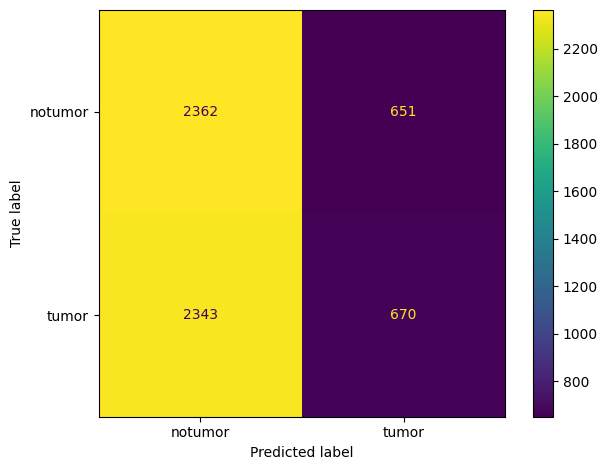

In [53]:
g_dict = test.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm6 = confusion_matrix(test.classes, predlist6)
display_cm6 = ConfusionMatrixDisplay(cm6, display_labels=classes)
display_cm6.plot()
plt.tight_layout()
plt.show()

In [54]:
preds6 = model6.predict_generator(test)
y_pred6 = np.argmax(preds6, axis=1)
print(y_pred6)

[0 0 0 ... 0 0 0]


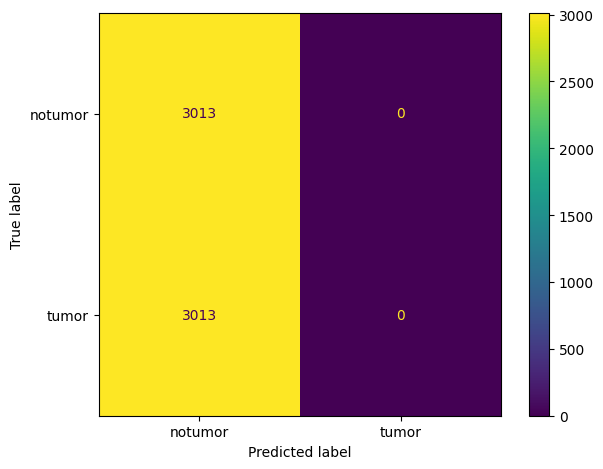

In [55]:
g_dict = test.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm6= confusion_matrix(test.classes, y_pred6)
display_cm6 = ConfusionMatrixDisplay(cm6, display_labels=classes)
display_cm6.plot()
plt.tight_layout()
plt.show()